In [23]:
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils
import seaborn as sns
from collections import Counter

from tqdm import tqdm
import src.dtw as dtw
from joblib import Parallel, delayed
import src.dba as dba
from sklearn.metrics import accuracy_score
from tslearn.barycenters import euclidean_barycenter
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import pickle
import time

from src.kmedoid import KMedoid
from src.kmean import KMeans
from src.rdm import RDm
from src.agh import AGH

In [24]:
# Path of the train and test dataset
train_set_path = 'UCRArchive_2018/CBF/CBF_TRAIN.tsv'
test_set_path = 'UCRArchive_2018/CBF/CBF_TEST.tsv'

# Extract the time series and classes for train and test set
train_labels, train_ts = utils.extract_ts_from_file(train_set_path)
test_labels, test_ts = utils.extract_ts_from_file(test_set_path)

$$ \textbf{Analyse des données} $$

In [26]:
print(f"L'ensemble d'entrainement est composé de {train_ts.shape[0]} échantillons de longueur {train_ts.shape[1]}")
print(f"L'ensemble de test est composé de {test_ts.shape[0]} échantillons de longueur {test_ts.shape[1]}")

L'ensemble d'entrainement est composé de 30 échantillons de longueur 128
L'ensemble de test est composé de 900 échantillons de longueur 128


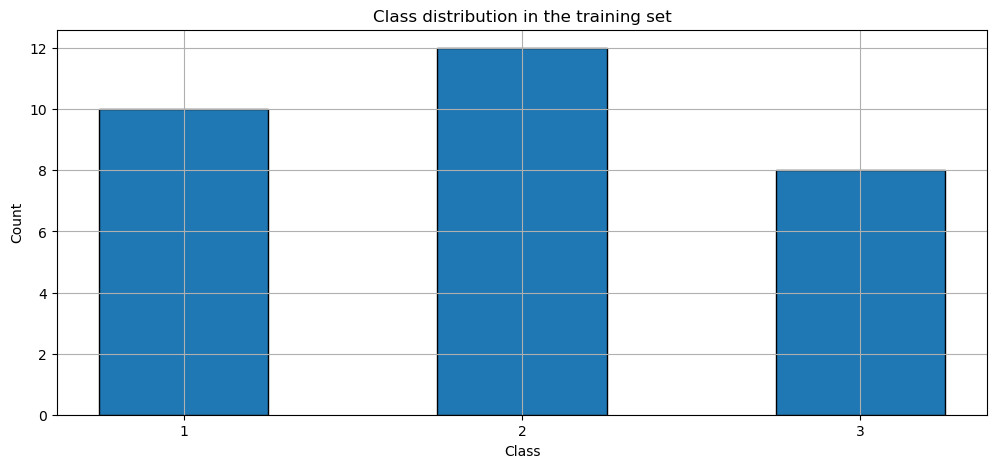

In [27]:
count = Counter(train_labels)

plt.figure(figsize = (12, 5))
plt.grid(True)
plt.bar(count.keys(), count.values(), width = 0.5, edgecolor = 'black')
plt.xlabel("Class")
plt.ylabel("Count")

plt.title("Class distribution in the training set")

plt.xticks([i for i in count.keys()])
plt.show()

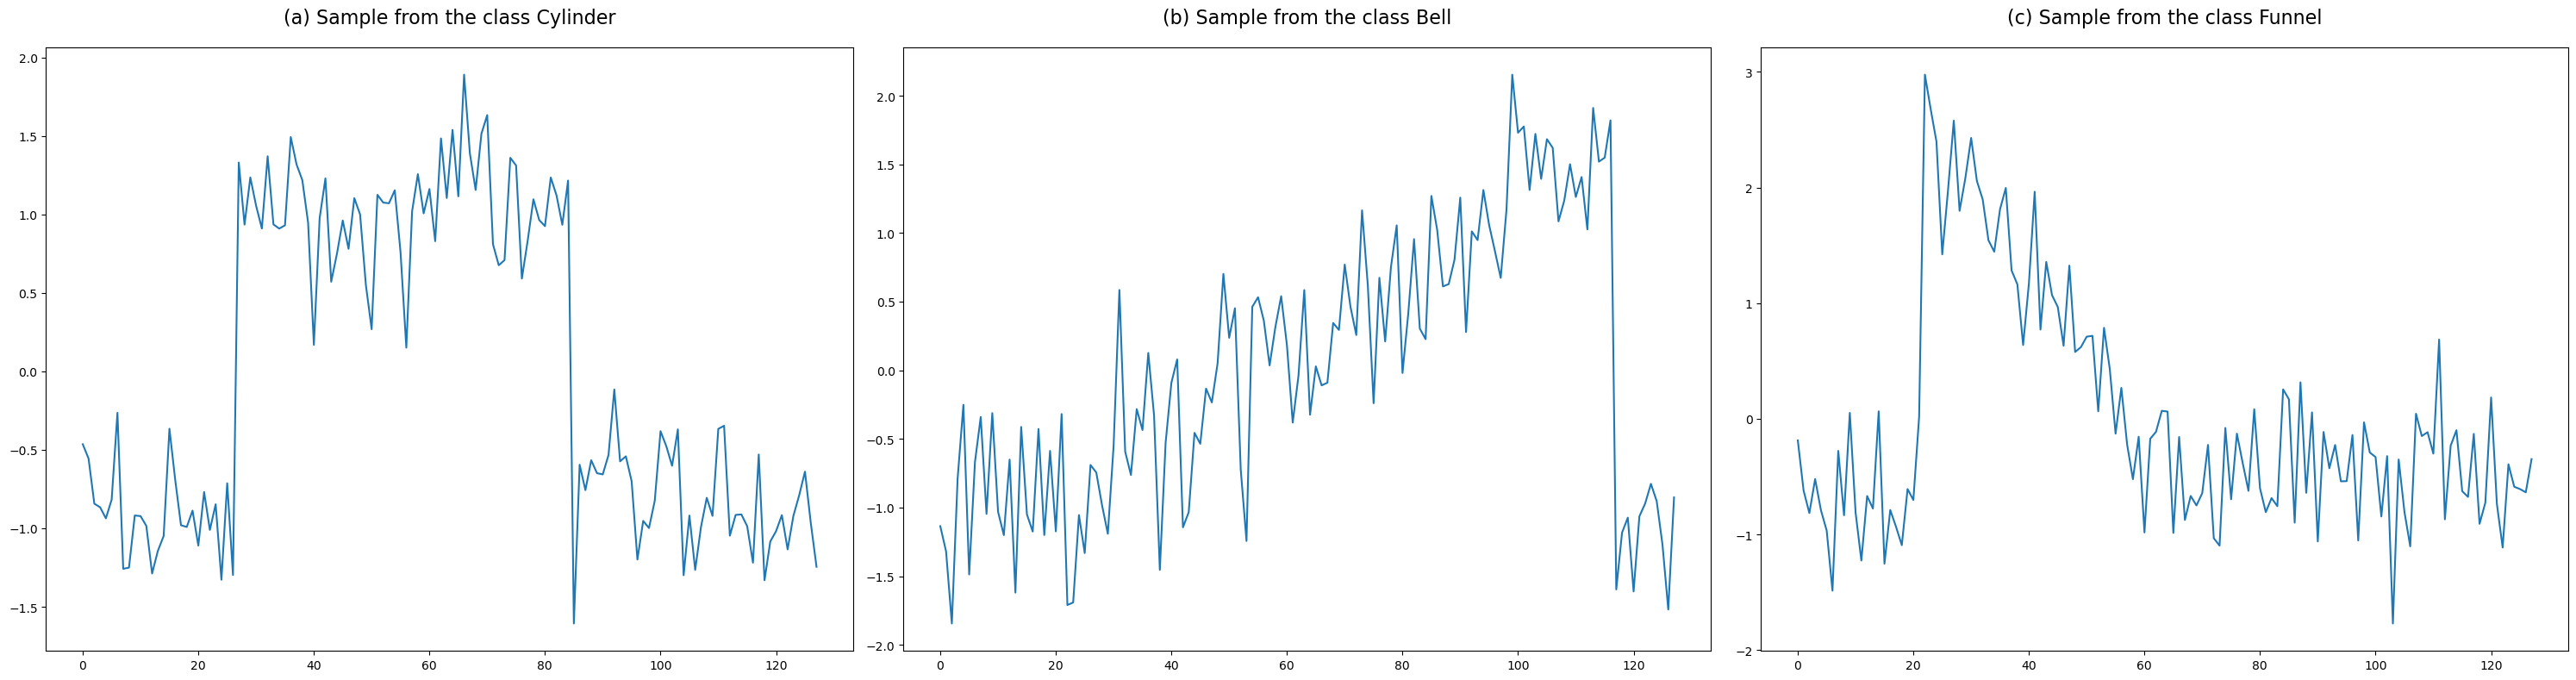

In [28]:
# Visualize samples from each of the three classes
fig, axes = plt.subplots(1, 3, figsize=(30, 8)) 
axes = axes.flatten() 

# Sample and plot the first class
sample_first_class = train_ts[train_labels == 1, :][0]
axes[0].plot(sample_first_class)
axes[0].set_title("(a) Sample from the class Cylinder", fontsize=16, pad=20)  # Larger title with padding to move it down

# Sample and plot the second class
sample_second_class = train_ts[train_labels == 2, :][0]
axes[1].plot(sample_second_class)
axes[1].set_title("(b) Sample from the class Bell", fontsize=16, pad=20)  # Larger title with padding to move it down

# Sample and plot the third class
sample_third_class = train_ts[train_labels == 3, :][0]
axes[2].plot(sample_third_class)
axes[2].set_title("(c) Sample from the class Funnel", fontsize=16, pad=20)  # Larger title with padding to move it down

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
EXEC = True
if EXEC :
    def compute_dtw(i, j):
        return i, j, dtw.get_dtw_distance(train_ts[i], train_ts[j])

    train_set_size = len(train_labels)

    DTW_distance_matrix = np.zeros([train_set_size, train_set_size])

    results = Parallel(n_jobs=-1)(delayed(compute_dtw)(i, j) 
                                for i in tqdm(range(train_set_size), disable = False) 
                                for j in range(i, train_set_size))

    # Remplissage de la matrice à partir des résultats
    for i, j, dist in results:
        DTW_distance_matrix[i, j] = dist
        DTW_distance_matrix[j, i] = dist
else : 
    DTW_distance_matrix = np.load('train_dtw_InsectWingbeatSound.npy')

100%|██████████| 30/30 [00:08<00:00,  3.62it/s]


In [30]:
np.save("train_dtw_CBF.npy", DTW_distance_matrix)

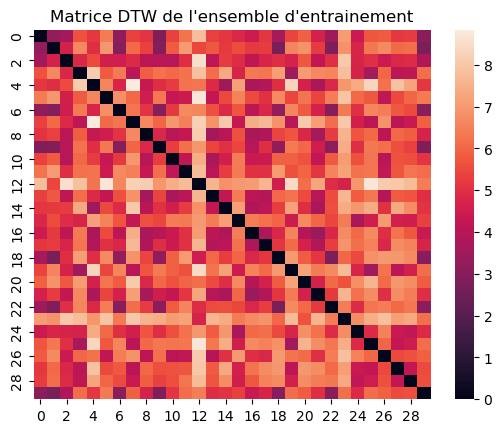

In [31]:
sns.heatmap(DTW_distance_matrix)
plt.title("Matrice DTW de l'ensemble d'entrainement")
plt.show()

In [32]:
a = Counter(train_labels)
print(a)

Counter({2: 12, 1: 10, 3: 8})


In [33]:
nb_class = len(Counter(train_labels).keys())
classes_index = {i:[] for i in Counter(train_labels).keys()}
for i, classe in enumerate(train_labels):
    classes_index[classe].append(i)

# Calcul de la "moyenne" de ces séries en utilisant la DBA et la distance euclidienne
class_dba = np.zeros([nb_class, 128])
class_euc = np.zeros([nb_class, 128])
for i in tqdm(sorted(list(classes_index.keys()))):
    class_dba[i-1] = dba.DBA(X = train_ts, 
                           D = train_ts[classes_index[i],:], 
                           id_D = classes_index[i], 
                           nb_iter = 10, 
                           dtw_matrix = DTW_distance_matrix, 
                           subset_size = len(classes_index[i]))
    
    class_euc[i-1] = np.squeeze(euclidean_barycenter(train_ts[classes_index[i],:]))

100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


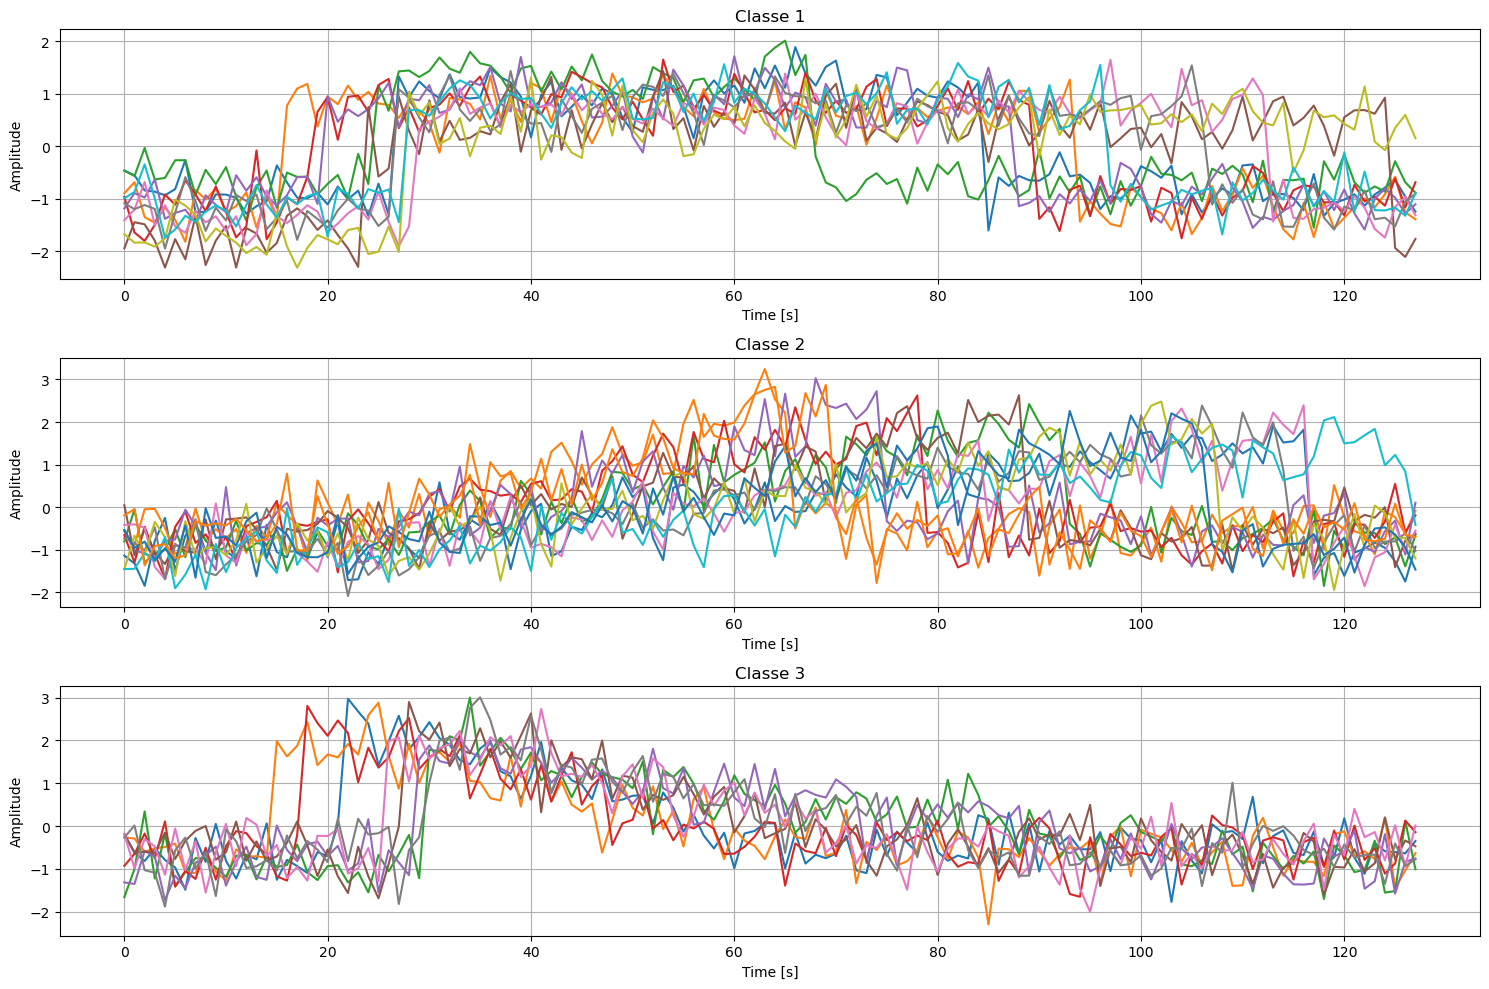

In [34]:
# Visualisons des échantillons de chacune des 11 classes
fig, axes = plt.subplots(3, 1, figsize=(15, 10)) 
axes = axes.flatten() 

for i in list(sorted(classes_index.keys())):
    for j in classes_index[i]: 
        axes[i-1].plot(train_ts[j,:], label=f"Échantillon {j+1}")
    axes[i-1].set_title(f"Classe {i}")
    axes[i-1].grid(True)
    axes[i-1].set_xlabel('Time [s]')
    axes[i-1].set_ylabel('Amplitude')

# for k in range(nb_class, 12):
#     fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

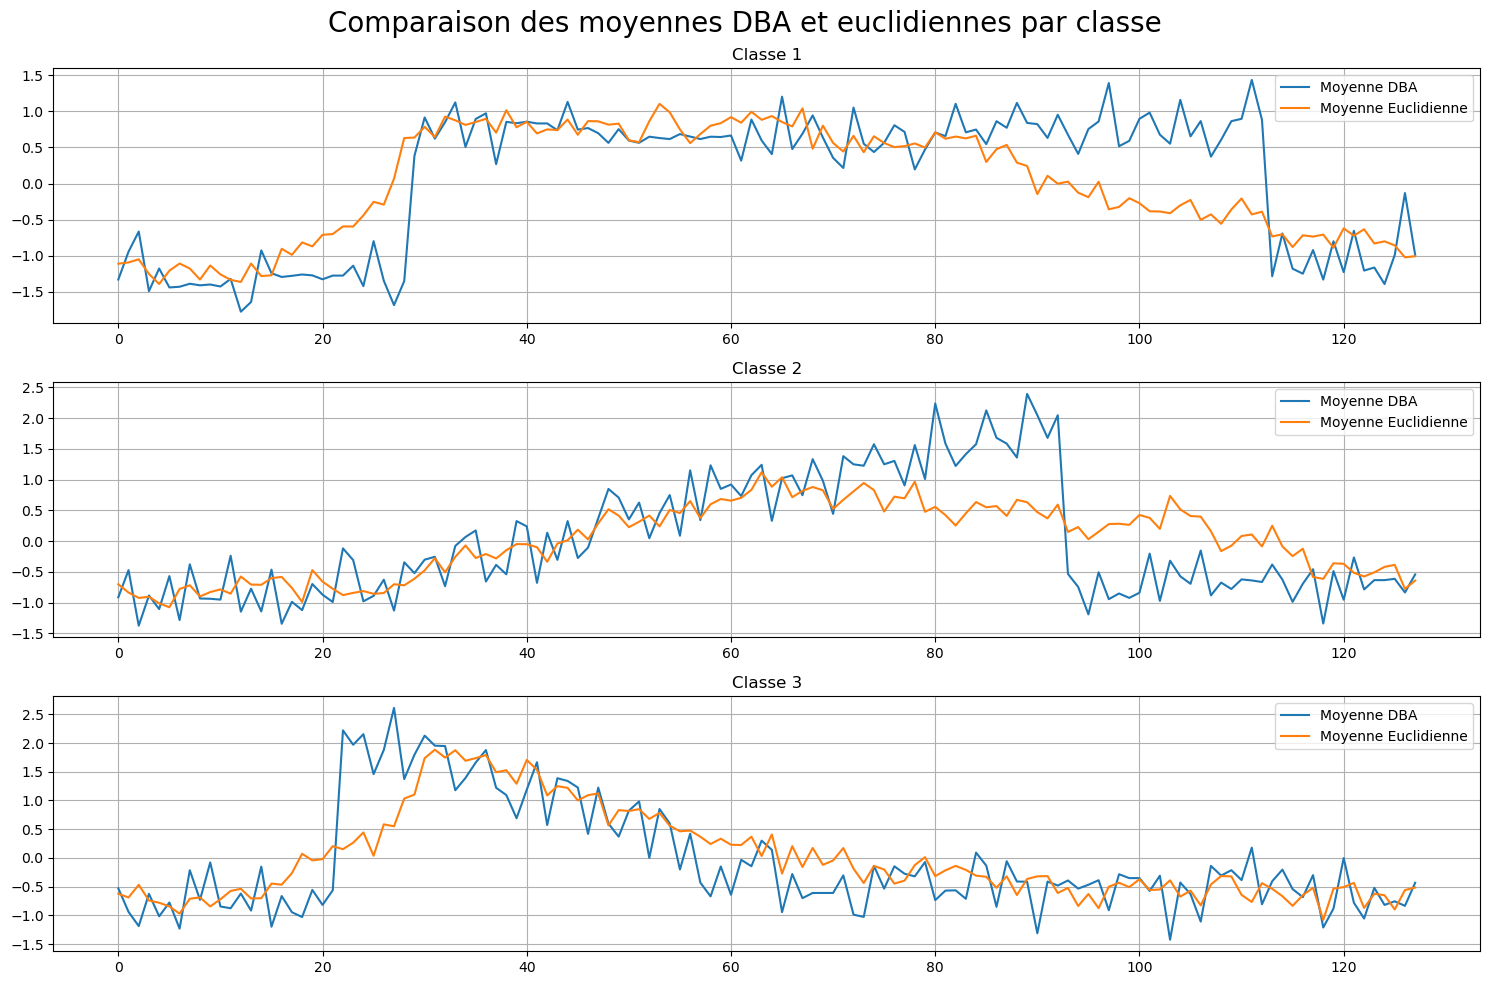

In [35]:
# Comparaison des moyennes euclidiennes et DBA
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()

for i in range(nb_class):
    axes[i].plot(class_dba[i], label='Moyenne DBA')
    axes[i].plot(class_euc[i], label='Moyenne Euclidienne')
    axes[i].set_title(f'Classe {i + 1}')
    axes[i].grid(True)
    axes[i].legend()
    axes[i].grid(True)

for j in range(nb_class, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparaison des moyennes DBA et euclidiennes par classe", fontsize = 20)
plt.tight_layout()
plt.show()


$$ \textbf{Evaluation des différentes méthodes} $$

### Condensation des données par K-Means

In [36]:
def get_KMeans_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KM_Classifier = KMeans(nb_clusters = n_clusters, max_iter = 20, eps = 0.1)
        KM_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KM_Classifier.centroids

    return centroids

# Pour paralléliser
def compute_centroids_for_n_clusters(n_clusters, train_ts, classes_id):
    return n_clusters, get_KMeans_centroids(
        ts_set=train_ts,
        classes_id=classes_id,
        n_clusters=n_clusters
    )

In [40]:
# Récupération des différentes classes du dataset
classes_id = np.unique(train_labels)

# Récupération des centroides pour différentes valeurs de n_clusters
n_clusters = np.arange(1, 9)
results = Parallel(n_jobs=-1)(delayed(compute_centroids_for_n_clusters)(
    n_clusters, train_ts, classes_id
) for n_clusters in n_clusters)

# Stockage des différents centroides dans un dictionnaire
all_centroids = {n_clusters: centroids for n_clusters, centroids in results}

In [41]:
k_means_acc = []
k_means_time = []

for i in tqdm(range(1, 9)):
    # Reshape the centroid array
    reshaped_centroid = all_centroids[i].reshape(nb_class*i, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * i)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    k_means_time.append(end_time - start_time)
    k_means_acc.append(accuracy_score(test_labels, predictions))

    print(f"Accuracy pour {i} clusters : {k_means_acc[-1]} | Complexité temporelle : {k_means_time[-1]}")

 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

Accuracy pour 1 clusters : 0.9466666666666667 | Complexité temporelle : 0.7332766056060791


 25%|██▌       | 2/8 [00:02<00:06,  1.11s/it]

Accuracy pour 2 clusters : 0.9922222222222222 | Complexité temporelle : 1.3715779781341553


 38%|███▊      | 3/8 [00:03<00:07,  1.45s/it]

Accuracy pour 3 clusters : 0.99 | Complexité temporelle : 1.8550381660461426


 50%|█████     | 4/8 [00:06<00:07,  1.78s/it]

Accuracy pour 4 clusters : 1.0 | Complexité temporelle : 2.2729079723358154


 62%|██████▎   | 5/8 [00:09<00:06,  2.13s/it]

Accuracy pour 5 clusters : 0.9966666666666667 | Complexité temporelle : 2.7497026920318604


 75%|███████▌  | 6/8 [00:12<00:04,  2.47s/it]

Accuracy pour 6 clusters : 0.9966666666666667 | Complexité temporelle : 3.1278786659240723


 88%|████████▊ | 7/8 [00:15<00:02,  2.80s/it]

Accuracy pour 7 clusters : 0.9977777777777778 | Complexité temporelle : 3.463650941848755


100%|██████████| 8/8 [00:19<00:00,  2.45s/it]

Accuracy pour 8 clusters : 0.9977777777777778 | Complexité temporelle : 4.0164954662323


### Condensation des données par Random selection

In [42]:
def get_Rdm_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing Random centroids for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        
        KM_Classifier = RDm(nb_clusters = n_clusters)
        KM_Classifier.fit(class_ts)

        centroids[idx] = KM_Classifier.centroids

    return centroids

In [43]:
rdm_acc = []
rdm_time = []

for n_clusters in range(1, 9) :
    rdm_centroids = get_Rdm_centroids(ts_set = train_ts, 
                                  classes_id = classes_id, 
                                  n_clusters = n_clusters)
    
    # Reshape the centroid array
    reshaped_centroid = rdm_centroids.reshape(nb_class * n_clusters, -1)

    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    rdm_acc.append(accuracy_score(test_labels, predictions))
    rdm_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {rdm_acc[-1]} | Prediction time : {rdm_time[-1]}")
    

3it [00:00, 3066.76it/s]


Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Accuracy pour 1 clusters : 0.9311111111111111 | Prediction time : 0.735821008682251


3it [00:00, ?it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 2 clusters : 0.9366666666666666 | Prediction time : 1.2042818069458008


3it [00:00, 3005.23it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 3 clusters : 0.9911111111111112 | Prediction time : 1.7657876014709473


3it [00:00, ?it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 4 clusters : 0.9933333333333333 | Prediction time : 2.143623113632202


3it [00:00, 3000.22it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 5 clusters : 0.9977777777777778 | Prediction time : 2.605686664581299


3it [00:00, 2594.41it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 6 clusters : 0.9755555555555555 | Prediction time : 3.615259885787964


3it [00:00, 3125.41it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 7 clusters : 0.9966666666666667 | Prediction time : 3.863870143890381


3it [00:00, 2951.66it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 8 clusters : 0.9966666666666667 | Prediction time : 4.231480360031128


### Condensation des données par K-Medoid

In [44]:
def get_KMedoid_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KMed_Classifier = KMedoid(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        KMed_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KMed_Classifier.centroids

    return centroids

In [45]:
kmed_acc = []
kmed_time = []

for n_clusters in tqdm(range(1, 9)):
    # Reshape the centroid array
    centroids = get_KMedoid_centroids(ts_set = train_ts, 
                                      classes_id = classes_id, 
                                      n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    kmed_acc.append(accuracy_score(test_labels, predictions))
    kmed_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {kmed_acc[-1]} | Prediction time : {kmed_time[-1]}")


3it [00:00, 911.94it/s]0:00<?, ?it/s]


Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations


 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

Accuracy pour 1 clusters : 0.9211111111111111 | Prediction time : 0.7737305164337158


3it [00:00, 999.91it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 25%|██▌       | 2/8 [00:02<00:07,  1.19s/it]

Accuracy pour 2 clusters : 0.9988888888888889 | Prediction time : 1.4579641819000244


3it [00:00, 810.34it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 38%|███▊      | 3/8 [00:04<00:07,  1.46s/it]

Accuracy pour 3 clusters : 0.9866666666666667 | Prediction time : 1.7608883380889893


3it [00:00, 855.40it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 50%|█████     | 4/8 [00:06<00:07,  1.77s/it]

Accuracy pour 4 clusters : 0.9833333333333333 | Prediction time : 2.228529214859009


3it [00:00, 899.29it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 62%|██████▎   | 5/8 [00:09<00:06,  2.16s/it]

Accuracy pour 5 clusters : 0.9966666666666667 | Prediction time : 2.8533170223236084


3it [00:00, 551.45it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 75%|███████▌  | 6/8 [00:12<00:05,  2.53s/it]

Accuracy pour 6 clusters : 0.9933333333333333 | Prediction time : 3.2272276878356934


3it [00:00, 750.23it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



 88%|████████▊ | 7/8 [00:16<00:02,  2.97s/it]

Accuracy pour 7 clusters : 0.9977777777777778 | Prediction time : 3.8508570194244385


3it [00:00, 538.51it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations



100%|██████████| 8/8 [00:20<00:00,  2.55s/it]

Accuracy pour 8 clusters : 0.9966666666666667 | Prediction time : 4.11508846282959


### AGH

In [46]:
def get_AGH_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        AGH_Classifier = AGH(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        AGH_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = AGH_Classifier.centroids

    return centroids

In [55]:
agh_acc = []
agh_time = []

for n_clusters in tqdm(range(1, 9)):
    # Reshape the centroid array
    centroids = get_AGH_centroids(ts_set = train_ts, 
                                classes_id = classes_id, 
                                n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    agh_acc.append(accuracy_score(test_labels, predictions))
    agh_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {agh_acc[-1]} | Prediction time : {agh_time[-1]}")

  0%|          | 0/8 [00:00<?, ?it/s]

Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:04,  1.55s/it]
 12%|█▎        | 1/8 [00:05<00:37,  5.41s/it]

Accuracy pour 1 clusters : 0.9411111111111111 | Prediction time : 0.7427685260772705


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:04,  1.50s/it]
 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

Accuracy pour 2 clusters : 0.96 | Prediction time : 1.193303108215332


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:04,  1.51s/it]
 38%|███▊      | 3/8 [00:17<00:29,  5.92s/it]

Accuracy pour 3 clusters : 0.9988888888888889 | Prediction time : 1.8000061511993408


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:04,  1.64s/it]
 50%|█████     | 4/8 [00:24<00:25,  6.37s/it]

Accuracy pour 4 clusters : 0.9822222222222222 | Prediction time : 2.1205551624298096


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:05,  1.73s/it]
 62%|██████▎   | 5/8 [00:32<00:20,  6.88s/it]

Accuracy pour 5 clusters : 0.9966666666666667 | Prediction time : 2.579653263092041


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:05,  1.92s/it]
 75%|███████▌  | 6/8 [00:41<00:15,  7.53s/it]

Accuracy pour 6 clusters : 0.9955555555555555 | Prediction time : 3.0091874599456787


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:05,  1.98s/it]
 88%|████████▊ | 7/8 [00:50<00:08,  8.16s/it]

Accuracy pour 7 clusters : 0.9977777777777778 | Prediction time : 3.522338628768921


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


3it [00:06,  2.16s/it]
100%|██████████| 8/8 [01:01<00:00,  7.63s/it]

Accuracy pour 8 clusters : 0.9977777777777778 | Prediction time : 3.9870193004608154


In [63]:
one_nn_clf = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = "dtw")

one_nn_clf.fit(train_ts, train_labels)

start_time = time.time()
predictions = one_nn_clf.predict(test_ts)
end_time = time.time()

print(f"1-NN DTW accuracy : {accuracy_score(test_labels, predictions)} | Prediction time : {end_time - start_time}")

1-NN DTW accuracy : 0.9966666666666667 | Prediction time : 5.282400608062744


In [49]:
1-accuracy_score(test_labels, predictions)

0.0033333333333332993

In [50]:
one_nn_error_rate = 1 - accuracy_score(test_labels, predictions)

$$\textbf{Visualisation des résultats}$$

[0.05888889 0.04       0.00111111 0.01777778 0.00333333 0.00444444
 0.00222222 0.00222222]
[0.07888889 0.00111111 0.01333333 0.01666667 0.00333333 0.00666667
 0.00222222 0.00333333]


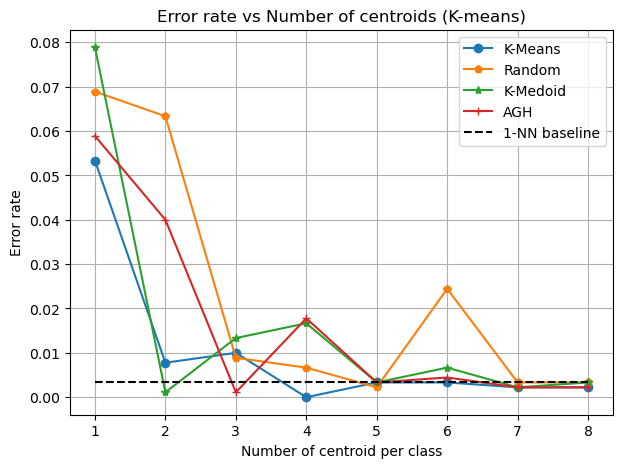

In [64]:
error_rate_km = 1 - np.array(k_means_acc)
error_rate_rdm = 1 - np.array(rdm_acc)
error_rate_k_med = 1 - np.array(kmed_acc)
error_rate_agh = 1 - np.array(agh_acc)
print(error_rate_agh)
print(error_rate_k_med)
n_centroids = list(range(1,9))
plt.figure(figsize = (7, 5))
plt.plot(n_centroids,error_rate_km, marker = 'o', label = "K-Means")
plt.plot(n_centroids,error_rate_rdm, marker = 'p', label = 'Random')
plt.plot(n_centroids,error_rate_k_med, marker ='*', label = 'K-Medoid')
plt.plot(n_centroids,error_rate_agh, marker = '+', label = 'AGH')
plt.plot(n_centroids,one_nn_error_rate*np.ones([8]), linestyle = '--', label = '1-NN baseline', color = 'black')
plt.xlabel('Number of centroid per class')
plt.ylabel('Error rate')
plt.grid(True)
plt.title('Error rate vs Number of centroids (K-means)')
plt.legend()
plt.show()

$$\textbf{Extension : Ajout d'une fenêtre de Warping}$$

### Condensation des données par K-Means

In [65]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [67]:
def get_Tsl_KMeans_centroids(ts_set, classes_id, n_clusters, scale = True):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        
        if scale :
            scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
            class_ts = scaler.fit_transform(class_ts)
        
        KM_Classifier = TimeSeriesKMeans(n_clusters = n_clusters,
                                          max_iter = 20, 
                                          tol = 0.1, 
                                          metric = "dtw",
                                          metric_params = {"sakoe_chiba_radius" : 3})
        KM_Classifier.fit(class_ts)

        centroids[idx] = KM_Classifier.cluster_centers_.squeeze()

    return centroids

In [68]:
km_w_acc_norm = []
km_w_time_norm = []

for n_clusters in tqdm(range(1, 9)) :
    km_centroids = get_Tsl_KMeans_centroids(ts_set = train_ts, 
                                  classes_id = classes_id, 
                                  n_clusters = n_clusters,
                                  scale = False)
    
    # Reshape the centroid array
    reshaped_centroid = km_centroids.reshape(nb_class * n_clusters, -1)

    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw',
                                             metric_params = {"sakoe_chiba_radius" : 3})   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    km_w_acc_norm.append(accuracy_score(test_labels, predictions))
    km_w_time_norm.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {km_w_acc_norm[-1]} | Prediction time : {km_w_time_norm[-1]}")

  0%|          | 0/8 [00:00<?, ?it/s]

Computing centroid for class1


3it [00:01,  1.76it/s]


Computing centroid for class2
Computing centroid for class3


 12%|█▎        | 1/8 [00:02<00:17,  2.49s/it]

Accuracy pour 1 clusters : 0.8355555555555556 | Prediction time : 0.775867223739624


Computing centroid for class1
Computing centroid for class2


3it [00:00,  8.98it/s]


Computing centroid for class3


 25%|██▌       | 2/8 [00:04<00:11,  1.93s/it]

Accuracy pour 2 clusters : 0.8855555555555555 | Prediction time : 1.1977496147155762


Computing centroid for class1


3it [00:00,  7.74it/s]


Computing centroid for class2
Computing centroid for class3


 38%|███▊      | 3/8 [00:06<00:09,  1.99s/it]

Accuracy pour 3 clusters : 0.8988888888888888 | Prediction time : 1.6451234817504883


Computing centroid for class1
Computing centroid for class2


3it [00:00,  8.96it/s]


Computing centroid for class3


 50%|█████     | 4/8 [00:08<00:08,  2.20s/it]

Accuracy pour 4 clusters : 0.9333333333333333 | Prediction time : 2.1657652854919434


Computing centroid for class1
Computing centroid for class2


3it [00:00,  8.00it/s]


Computing centroid for class3


 62%|██████▎   | 5/8 [00:11<00:07,  2.48s/it]

Accuracy pour 5 clusters : 0.9466666666666667 | Prediction time : 2.587038278579712


Computing centroid for class1
Computing centroid for class2


3it [00:00,  7.14it/s]


Computing centroid for class3


 75%|███████▌  | 6/8 [00:14<00:05,  2.75s/it]

Accuracy pour 6 clusters : 0.9644444444444444 | Prediction time : 2.863710880279541


Computing centroid for class1
Computing centroid for class2


3it [00:00,  6.95it/s]


Computing centroid for class3


 88%|████████▊ | 7/8 [00:18<00:03,  3.00s/it]

Accuracy pour 7 clusters : 0.9344444444444444 | Prediction time : 3.066361665725708


Computing centroid for class1
Computing centroid for class2


3it [00:00,  6.52it/s]


Computing centroid for class3


100%|██████████| 8/8 [00:22<00:00,  2.76s/it]

Accuracy pour 8 clusters : 0.9533333333333334 | Prediction time : 3.2326292991638184


### Condensation des données par Random Selection

In [70]:
rdm_const_acc = []
rdm_const_time = []

for n_clusters in range(1, 9) :
    rdm_centroids = get_Rdm_centroids(ts_set = train_ts, 
                                  classes_id = classes_id, 
                                  n_clusters = n_clusters)
    
    # Reshape the centroid array
    reshaped_centroid = rdm_centroids.reshape(nb_class * n_clusters, -1)

    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw',
                                             metric_params={"sakoe_chiba_radius": 3})   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    rdm_const_acc.append(accuracy_score(test_labels, predictions))
    rdm_const_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {rdm_const_acc[-1]} | Prediction time : {rdm_const_time[-1]}")

3it [00:00, 1271.77it/s]


Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Accuracy pour 1 clusters : 0.5822222222222222 | Prediction time : 0.7698338031768799


3it [00:00, 2334.06it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 2 clusters : 0.7044444444444444 | Prediction time : 1.1418201923370361


3it [00:00, 2979.61it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 3 clusters : 0.8144444444444444 | Prediction time : 1.5223827362060547


3it [00:00, ?it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 4 clusters : 0.7655555555555555 | Prediction time : 2.1832830905914307


3it [00:00, 2538.92it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 5 clusters : 0.8955555555555555 | Prediction time : 2.3113744258880615


3it [00:00, 2099.25it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 6 clusters : 0.8822222222222222 | Prediction time : 2.5797524452209473


3it [00:00, 2154.98it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 7 clusters : 0.8744444444444445 | Prediction time : 2.8682808876037598


3it [00:00, 2967.67it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3


Accuracy pour 8 clusters : 0.9177777777777778 | Prediction time : 3.3303651809692383


In [71]:


one_nn_clf = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = "dtw",
                                            metric_params = {"sakoe_chiba_radius" : 3})

one_nn_clf.fit(train_ts, train_labels)

start_time = time.time()
predictions = one_nn_clf.predict(test_ts)
end_time = time.time()

print(f"1-NN DTW accuracy : {accuracy_score(test_labels, predictions)} | Prediction time : {end_time - start_time}")

1-NN DTW accuracy : 0.9511111111111111 | Prediction time : 4.295840263366699


In [72]:
one_nn_w_error_rate = 1 - accuracy_score(test_labels, predictions)

In [73]:
one_nn_w_error_rate = 1 - accuracy_score(test_labels, predictions)

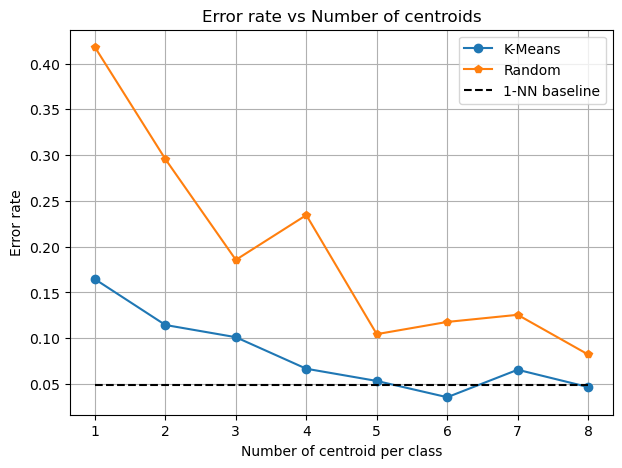

In [80]:
error_rate_km = np.ones([8]) - km_w_acc_norm
error_rate_rdm = np.ones([8]) - rdm_const_acc


plt.figure(figsize = (7, 5))
plt.plot(np.arange(1, 9), error_rate_km, marker = 'o', label = "K-Means")
plt.plot(np.arange(1, 9), error_rate_rdm, marker = 'p', label = 'Random')
plt.plot(np.arange(1, 9), one_nn_w_error_rate*np.ones([8]), linestyle = '--', label = '1-NN baseline', color = 'black')
plt.xlabel('Number of centroid per class')
plt.ylabel('Error rate')
plt.grid(True)
plt.title('Error rate vs Number of centroids')
plt.legend()
plt.show()